## Finding entity classes in embeddings

In this notebook we're going to use embeddings to find entity classes and how they correlate with other things

In [2]:
%matplotlib inline

from sklearn import svm
from keras.utils import get_file
import os
import gensim
import numpy as np
import random
import requests
import geopandas as gpd
from IPython.core.pylabtools import figsize
figsize(12, 8)
import pycountry
import csv

as before, let's load up the model

In [3]:
MODEL = 'GoogleNews-vectors-negative300.bin'
path = get_file(MODEL + '.gz', 'https://s3.amazonaws.com/dl4j-distribution/%s.gz' % MODEL)
unzipped = os.path.join('generated', MODEL)
if not os.path.isfile(unzipped):
    with open(unzipped, 'wb') as fout:
        zcat = subprocess.Popen(['zcat'],
                          stdin=open(path),
                          stdout=fout
                         )
        zcat.wait()

Most similar to a bunch of countries are some other countries!

In [4]:
model = gensim.models.KeyedVectors.load_word2vec_format(unzipped, binary=True)
model.most_similar(positive=['Germany'])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Austria', 0.7461062073707581),
 ('German', 0.7178748846054077),
 ('Germans', 0.6628648042678833),
 ('Switzerland', 0.6506868600845337),
 ('Hungary', 0.6504982709884644),
 ('Germnay', 0.649348258972168),
 ('Netherlands', 0.6437496542930603),
 ('Cologne', 0.6430779695510864),
 ('symbol_RSTI', 0.6389946937561035),
 ('Annita_Kirsten', 0.6342948079109192)]

In [5]:
model.most_similar(positive=['Annita_Kirsten'])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Braustolz_GmbH', 0.7545095682144165),
 ('DIARY_Economic_Indicators', 0.7334568500518799),
 ('##-##_#####_Burscheid', 0.7307888269424438),
 ('WKN_A#N#Y#_Symbol', 0.7260339260101318),
 ('Hoevelaken', 0.7067489624023438),
 ('BMW_###si_1min_##.###secs', 0.7050351500511169),
 ('Primera_EUROPE', 0.699741005897522),
 ('symbol_RSTI', 0.6925466656684875),
 ('Severin_Freund', 0.6898956894874573),
 ('However_Joern_Lauterjung', 0.688573956489563)]

No we'll create a training set with countries and non countries and get a support vector machine to learn the difference.

In [6]:
countries = list(csv.DictReader(open('data/countries.csv')))
countries[:10]

[OrderedDict([('name', 'Canada'), ('cc', 'ca'), ('cc3', 'can')]),
 OrderedDict([('name', 'Turkmenistan'), ('cc', 'tm'), ('cc3', 'tkm')]),
 OrderedDict([('name', 'Ethiopia'), ('cc', 'et'), ('cc3', 'eth')]),
 OrderedDict([('name', 'Swaziland'), ('cc', 'sz'), ('cc3', 'swz')]),
 OrderedDict([('name', 'Czech_Republic'), ('cc', 'cz'), ('cc3', 'cze')]),
 OrderedDict([('name', 'Cameroon'), ('cc', 'cm'), ('cc3', 'cmr')]),
 OrderedDict([('name', 'UAE'), ('cc', 'ae'), ('cc3', 'are')]),
 OrderedDict([('name', 'Liberia'), ('cc', 'lr'), ('cc3', 'lbr')]),
 OrderedDict([('name', 'Netherlands'), ('cc', 'nl'), ('cc3', 'nld')]),
 OrderedDict([('name', 'East_Timor'), ('cc', 'tl'), ('cc3', 'tls')])]

In [7]:
positive = [x['name'] for x in random.sample(countries, 40)]
negative = random.sample(model.vocab.keys(), 5000)
negative[:4]

['tackle_Haloti_Ngata',
 'stab_everybody_Doneisha',
 'BLOOMSBURG_Bloomsburg_University',
 'Murle']

In [8]:
labelled = [(p, 1) for p in positive] + [(n, 0) for n in negative]
random.shuffle(labelled)
X = np.asarray([model[w] for w, l in labelled])
y = np.asarray([l for w, l in labelled])
X.shape, y.shape

((5040, 300), (5040,))

In [9]:
TRAINING_FRACTION = 0.3
cut_off = int(TRAINING_FRACTION * len(labelled))
clf = svm.SVC(kernel='linear')
clf.fit(X[:cut_off], y[:cut_off]) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

We did alright, 99.9% precision:

In [10]:
res = clf.predict(X[cut_off:])

missed = [country for (pred, truth, country) in 
 zip(res, y[cut_off:], labelled[cut_off:]) if pred != truth]

100 - 100 * float(len(missed)) / len(res), missed

(99.88662131519274,
 [('England', 1), ('Reunion', 1), ('Tonga', 1), ('Monaco', 1)])

In [11]:
all_predictions = clf.predict(model.syn0)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  if __name__ == '__main__':


In [15]:
res = []
for word, pred in zip(model.index2word, all_predictions):
    if pred:
        res.append(word)
#         if len(res) == 150:
#             break
random.sample(res, 10)

['Timor_Leste',
 'Australia',
 'USA',
 'N.Ireland',
 'Quang_Ninh',
 'Britain',
 'Tijuana_Mexico',
 'tribal_regions',
 'Untied_States',
 'Madagascar']

In [16]:
len(res)

735

In [17]:
country_to_idx = {country['name']: idx for idx, country in enumerate(countries)}
country_vecs = np.asarray([model[c['name']] for c in countries])
country_vecs.shape

(184, 300)

Quick sanity check to see what is similar to Canada:

In [18]:
dists = np.dot(country_vecs, country_vecs[country_to_idx['Canada']])
for idx in reversed(np.argsort(dists)[-10:]):
    print(countries[idx]['name'], dists[idx])

Canada 7.544024
New_Zealand 3.9619699
Finland 3.9392405
Puerto_Rico 3.838145
Jamaica 3.8102937
Sweden 3.8042789
Slovakia 3.7038739
Australia 3.671101
Bahamas 3.6240416
United_States 3.537434


Ranking countries for a specific term:

In [33]:
countries[:5]

[OrderedDict([('name', 'Canada'), ('cc', 'ca'), ('cc3', 'can')]),
 OrderedDict([('name', 'Turkmenistan'), ('cc', 'tm'), ('cc3', 'tkm')]),
 OrderedDict([('name', 'Ethiopia'), ('cc', 'et'), ('cc3', 'eth')]),
 OrderedDict([('name', 'Swaziland'), ('cc', 'sz'), ('cc3', 'swz')]),
 OrderedDict([('name', 'Czech_Republic'), ('cc', 'cz'), ('cc3', 'cze')])]

In [35]:
np.argsort([41, 2, 12, 54, 100])

array([1, 2, 0, 3, 4])

In [67]:
[x for x in reversed(np.argsort([41, 2, 12, 54, 100]))]

[4, 3, 0, 2, 1]

In [19]:
def rank_countries(term, topn=10, field='name'):
    if not term in model:
        return []
    vec = model[term]
    dists = np.dot(country_vecs, vec)
    return [(countries[idx][field], float(dists[idx])) 
            for idx in reversed(np.argsort(dists)[-topn:])]

In [20]:
rank_countries('cricket')

[('Sri_Lanka', 5.92276668548584),
 ('Zimbabwe', 5.336524963378906),
 ('Bangladesh', 5.192488670349121),
 ('Pakistan', 4.948408126831055),
 ('Guyana', 3.9162840843200684),
 ('Barbados', 3.757995128631592),
 ('India', 3.7504398822784424),
 ('South_Africa', 3.6561501026153564),
 ('New_Zealand', 3.64202880859375),
 ('Fiji', 3.608567714691162)]

Now let's visualize this on a world map:

In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


We can now plot some maps!

<Figure size 1296x1008 with 0 Axes>

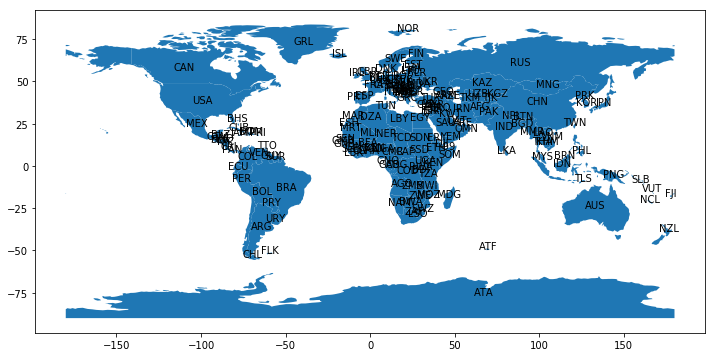

In [56]:
world['coords'] = world['geometry'].apply(lambda x: x.representative_point().coords[:])
world['coords'] = world['coords'].apply(lambda x: x[0])

plt.figure(figsize = (18, 14))
world.plot()
for idx, row in world.iterrows():
    plt.annotate(s=row['iso_a3'], xy=row['coords'],
                 horizontalalignment='center')

In [ ]:
world.plot()

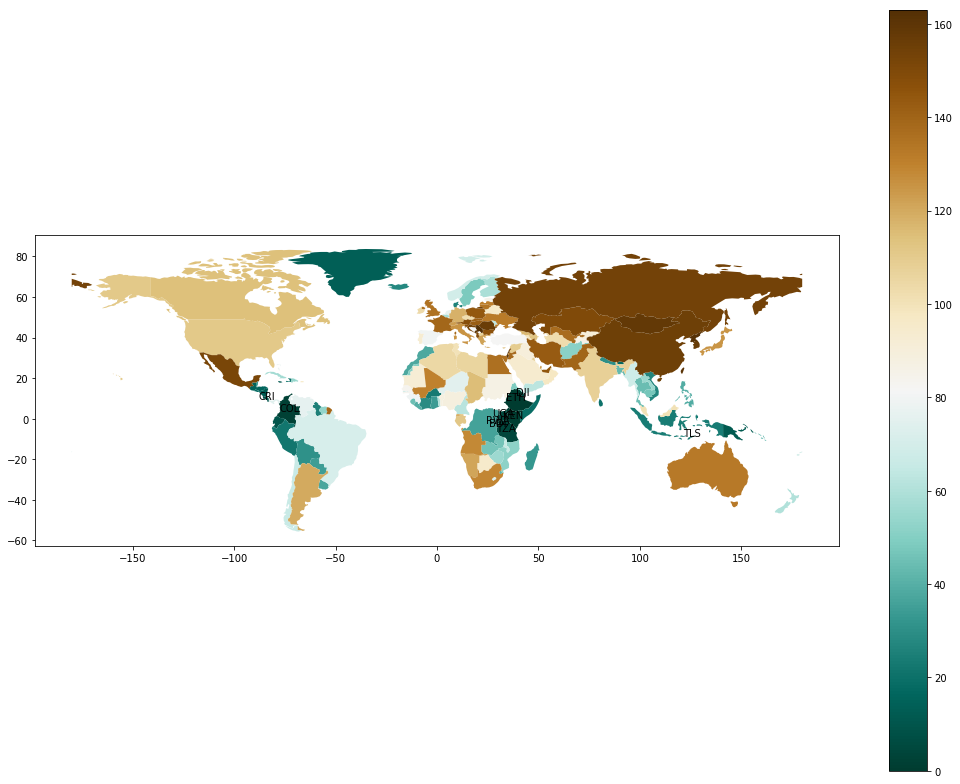

In [116]:
import matplotlib.pyplot as plt
def map_term(term):
    d = {k.upper(): v for k, v in rank_countries(term, topn=0, field='cc3')}
    world[term] = world['iso_a3'].map(d)
    world[term] /= world[term].max()
    
    world.sort_values(term, ascending = False, inplace = True)
    # Get ranking
    world[f'{term}-rank'] = [i for i in range(len(world))]
    
    fig, ax = plt.subplots(1, 1, figsize = (18, 14));
    
    # Plot with colorbar
    world.dropna().plot(f'{term}-rank', 
                        cmap=plt.cm.BrBG_r, 
                        ax = ax, legend = True)
    
    # Create a subset for plotting country symbols
    subset = world.iloc[:10]
    
    for idx, row in subset.iterrows():
        plt.annotate(s=row['iso_a3'], xy=row['coords'],
                     horizontalalignment='center')
map_term('coffee')

In [117]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,coffee,cricket,China,literature,science,coords,coffee-rank,cricket-rank,China-rank,literature-rank,science-rank
51,85237338.0,Africa,Ethiopia,ETH,68770.0,"POLYGON ((37.90607000000011 14.95943000000017,...",1.000000,0.102985,0.447282,0.620376,0.711298,"(38.72639118584689, 9.362030000000146)",0,54,162,109,37
84,39002772.0,Africa,Kenya,KEN,61510.0,"POLYGON ((40.993 -0.85829, 41.58513 -1.68325, ...",0.997895,0.458431,0.373437,-0.048206,0.295816,"(37.512972045317696, 0.31240676893094815)",1,42,24,125,50
35,45644023.0,South America,Colombia,COL,395400.0,POLYGON ((-75.37322323271385 -0.15203175212045...,0.983746,0.031409,0.408432,0.142438,0.426161,"(-72.48645806790587, 3.9686211206173923)",2,103,68,66,80
11,8988091.0,Africa,Burundi,BDI,3102.0,POLYGON ((29.33999759290035 -4.499983412294092...,0.970269,0.276264,0.309757,-0.360537,0.426557,"(29.957131893468294, -3.4639484594904673)",3,6,159,0,55
164,41048532.0,Africa,Tanzania,TZA,54250.0,POLYGON ((33.9037111971046 -0.9499999999999886...,0.969494,0.268171,0.353667,-0.149819,0.536838,"(34.14206440427045, -6.207829437269652)",4,119,69,28,57


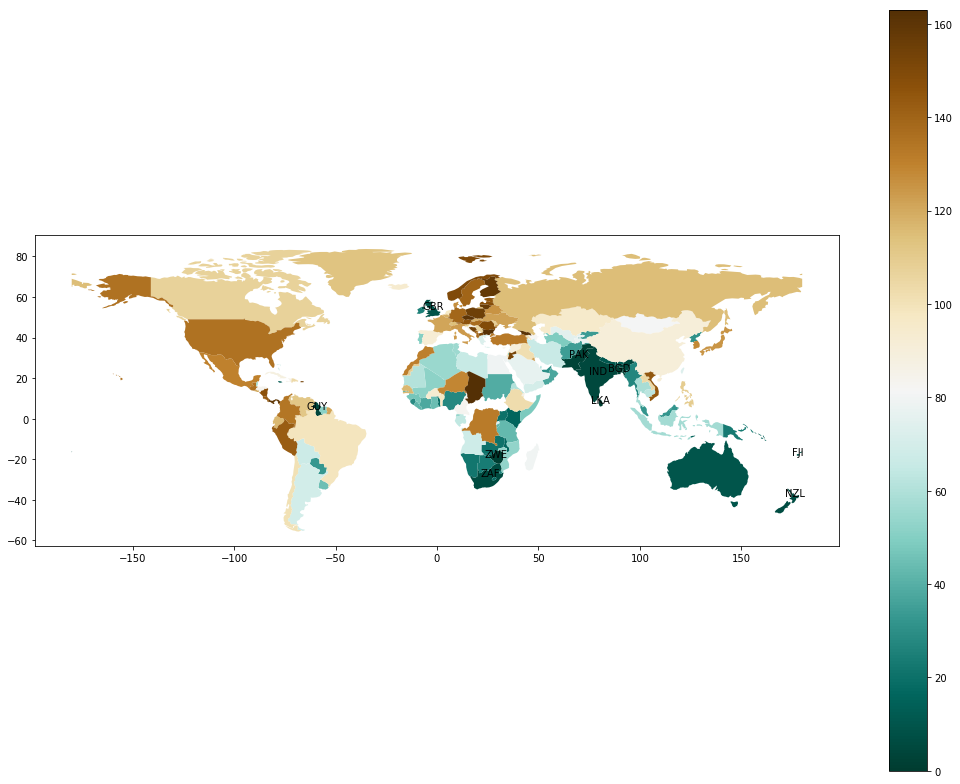

In [118]:
map_term('cricket')

In [119]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,coffee,cricket,China,literature,science,coords,coffee-rank,cricket-rank,China-rank,literature-rank,science-rank
94,21324791.0,Asia,Sri Lanka,LKA,91870.0,"POLYGON ((81.7879590188914 7.523055324733164, ...",0.681393,1.000000,0.454778,0.459989,0.417686,"(80.68375212082876, 7.861949367703275)",21,0,90,118,43
176,12619600.0,Africa,Zimbabwe,ZWE,9323.0,"POLYGON ((31.19140913262129 -22.2515096981724,...",0.469837,0.901019,0.493543,-0.242866,0.224536,"(29.321720518595246, -19.003749281492738)",56,1,74,98,39
15,156050883.0,Asia,Bangladesh,BGD,224000.0,"POLYGON ((92.67272098182556 22.04123891854125,...",0.542793,0.876700,0.486789,0.329762,0.297647,"(89.87623895192834, 23.563936672453586)",43,2,157,128,69
122,176242949.0,Asia,Pakistan,PAK,427300.0,"POLYGON ((75.15802778514092 37.13303091078912,...",0.101868,0.835489,0.491921,0.230078,0.433335,"(70.0926280198014, 30.35765635835316)",140,3,-1,-1,-1
67,772298.0,South America,Guyana,GUY,2966.0,POLYGON ((-59.75828487815919 8.367034816924047...,0.671423,0.661225,0.262904,0.186136,0.295325,"(-58.845385285127406, 4.913343817561277)",25,4,125,42,110


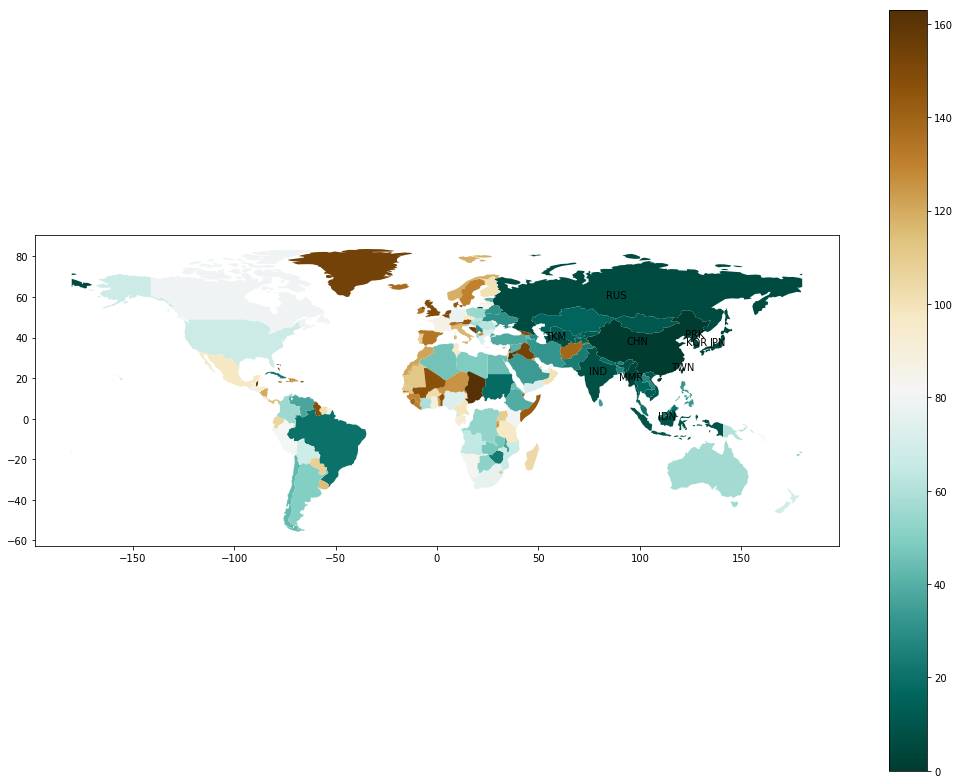

In [120]:
map_term('China')

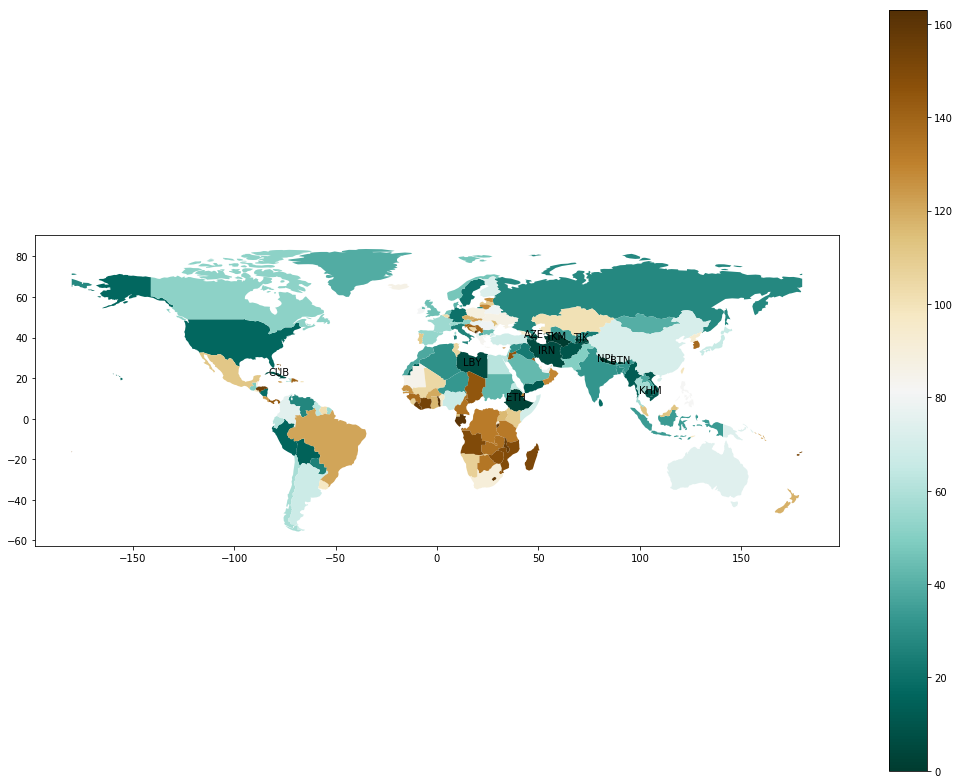

In [121]:
map_term('literature')

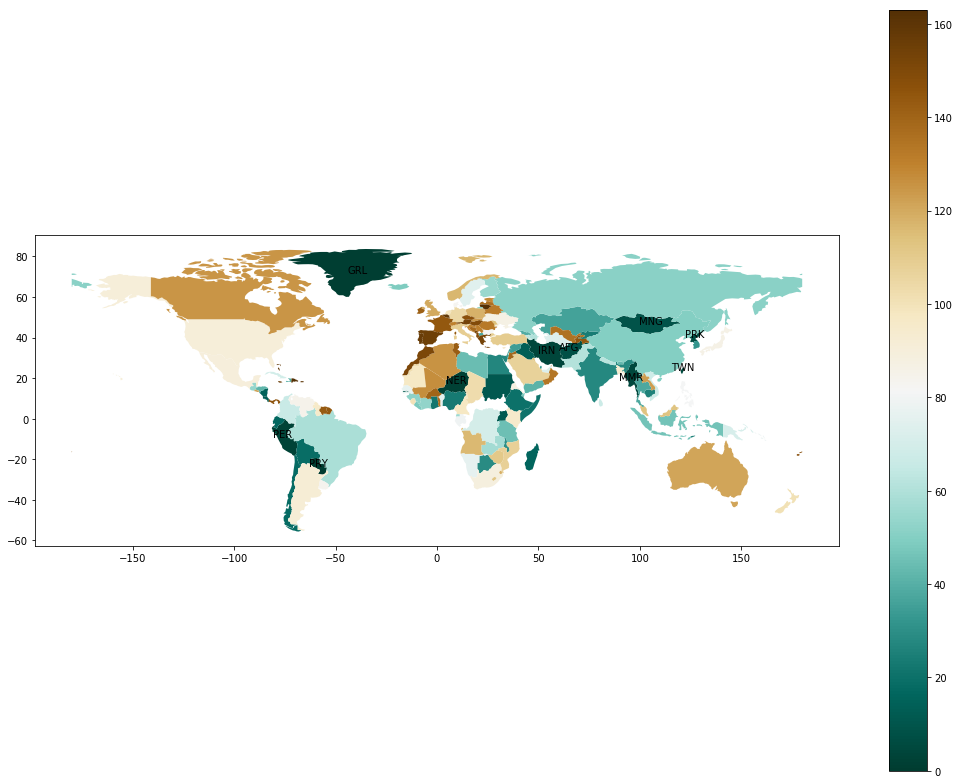

In [123]:
map_term('science')

In [124]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,coffee,cricket,China,literature,science,coords,coffee-rank,cricket-rank,China-rank,literature-rank,science-rank
131,6995655.0,South America,Paraguay,PRY,28890.0,POLYGON ((-62.68505713565789 -22.2490292294223...,0.576236,0.309586,0.341902,0.382607,1.000000,"(-58.63741587062309, -23.11380848561074)",35,33,108,25,0
65,57600.0,North America,Greenland,GRL,1100.0,"POLYGON ((-46.76379 82.62796, -43.40644 83.225...",0.764258,0.074117,0.243299,0.294588,0.983890,"(-39.28314849217472, 71.8673)",14,113,154,39,1
114,15306252.0,Africa,Niger,NER,10040.0,"POLYGON ((2.15447350424995 11.94015005131342, ...",0.394157,0.038049,0.310169,0.310815,0.924738,"(9.774101005400071, 17.39008871100316)",75,129,126,33,2
124,29546963.0,South America,Peru,PER,247300.0,POLYGON ((-69.59042375352405 -17.5800118954193...,0.679339,0.022840,0.373394,0.469455,0.906539,"(-75.87473849257125, -9.247523085164648)",22,142,81,16,3
75,66429284.0,Asia,Iran,IRN,841700.0,"POLYGON ((53.92159793479556 37.19891836196126,...",0.080895,0.190645,0.467860,0.567975,0.902496,"(54.118245053800806, 32.32603750256677)",143,66,32,6,4


In [125]:
model.most_similar('Jordan')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Pete_Yost_Lara_Jakes', 0.698294997215271),
 ('Salah_Anani_Palestinian', 0.6901426315307617),
 ('Singer_Montell', 0.6694633960723877),
 ('Judge_Adalberto', 0.6650310754776001),
 ('W._Charness', 0.660664439201355),
 ('nurse_anesthetist_Sally', 0.6495840549468994),
 ('Jordon', 0.6274502277374268),
 ('AMMAN_Jordan_Archaeologists', 0.6252423524856567),
 ('Deputy_Controller_Hallye', 0.6235604286193848),
 ('Fayetteville_Mayor_Lioneld', 0.616828441619873)]

In [126]:
model.most_similar('Superior')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('Alessandro_Ceci', 0.6039808392524719),
 ('Services_NASDAQ_SWSI', 0.5925741195678711),
 ('Portage', 0.5634398460388184),
 ('Superior_WI', 0.5400094985961914),
 ('Laura_Podgornik_reports', 0.5376843214035034),
 ('www.superiorplus.com', 0.5348039865493774),
 ('Dennis_Rahkonen', 0.5287622213363647),
 ('Eben_Junction', 0.5242437124252319),
 ('Fraser_Shipyards', 0.5206637978553772),
 ('Algoma', 0.5201526880264282)]